## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [7]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

In [8]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [10]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text =  ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [11]:
text[:100]

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as "

In [12]:
tokens = sorted(set(text))

In [109]:
num_tokens = len(tokens)
num_tokens

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [141]:
# dict <index>:<char>
# Your great code here
token_to_id = {
    token: idx for idx, token in enumerate(tokens)
}
# dict <char>:<index>
# Your great code here
idx_to_token = {idx: word for word, idx in token_to_idx.items()}

In [23]:
encoded = np.array([token_to_idx[ch] for ch in text])

In [143]:
class MyModel(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [144]:
model = MyModel()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(text.split(), 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [145]:
logp_seq = model(batch_ix)

loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

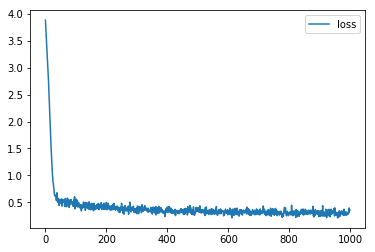

In [146]:
MAX_LENGTH = 32

for i in range(1000):
    batch_ix = to_matrix(sample(text.split(), 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    logp_seq = model(batch_ix)
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [147]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [148]:
for _ in range(10):
    print(generate_sample(MyModel, seed_phrase='h'))

TypeError: initial_state() missing 1 required positional argument: 'self'

In [121]:
seed_phrase='h'
x_sequence = [token_to_idx[token] for token in seed_phrase]
x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
# hid_state = char_rnn.initial_state(batch_size=1)
    
#     #feed the seed phrase, if any
for i in range(len(seed_phrase) - 1):
    print(x_sequence[:, -1].shape, hid_state.shape)
    out, hid_state = MyModel(x_sequence[:, i], hid_state)
    
#     #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = MyModel(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    print(''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]]))

In [122]:
x_sequence

tensor([[[19]]])

In [90]:
def get_batches(arr, batch_size, seq_length):
    # determine the flattened batch size, i.e. sequence length times batch size
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
#     arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, len(arr), seq_length):
        # The features
        x = arr[n:n+seq_length]
        # The targets
        y = arr[n:n+seq_length]
        y[0] = 'a'
        print(y)
        try:
            print(len(x[1:]))
            print(len(y))
            y[:-1] = x[1:]
            y[-1] = arr[n+seq_length]
        except IndexError:
            print(x[1:])
            y[:-1], y[-1] = x[1:], arr[0]
        return x, y

In [91]:
text[99400:99500]

";\n  i, sick withal, the help of bath desired,\n  and thither hied, a sad distemper'd guest,\n    but f"

In [92]:
seq_length = 100
get_batches(text, 32, seq_length)

TypeError: 'str' object does not support item assignment

In [93]:

def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [94]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [95]:
# Your code here
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE
        
        h_next = torch.tanh(h_next) # YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)# YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [96]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss() # YOUR CODE HERE

In [97]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [98]:
def to_matrix(names, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [99]:
batch_ix = to_matrix(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

In [100]:
predictions_logp = logp_seq[:, :]
actual_next_tokens = batch_ix[:, :]

# .contiguous() method checks that tensor is stored in the memory correctly to 
# get its view of desired shape.

loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
                  actual_next_tokens.contiguous().view(-1))

In [101]:
loss

tensor(3.5590, grad_fn=<NllLossBackward>)

In [102]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(text[::5000]))
print(to_matrix(text[::5000]))

 
u
h
o
f
r
t
p


y
m
,
s
l
 
o
n
m
m
c
r
[[ 1]
 [32]
 [19]
 [26]
 [17]
 [29]
 [31]
 [27]
 [ 0]
 [36]
 [24]
 [ 6]
 [30]
 [23]
 [ 1]
 [26]
 [25]
 [24]
 [24]
 [14]
 [29]]


In [103]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

31

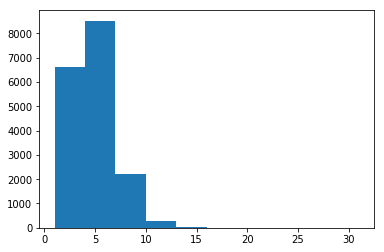

In [104]:
lens = []
for i in text.split():
    lens.append(len(i))
plt.hist(lens)
np.max(lens)

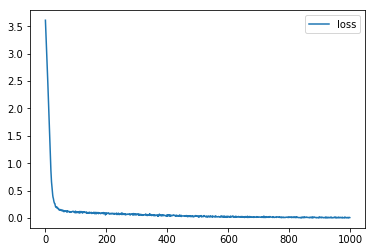

In [26]:
MAX_LENGTH = 31

for i in range(1000):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, :]# YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, len(tokens)),
        actual_next_tokens.contiguous().view(-1)
    ) # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
# Your plot here

In [116]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [117]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase='h'))

torch.Size([1, 1, 1]) tensor([[[19]]]) torch.Size([1, 64])


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 2 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:603

In [65]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

TypeError: generate_sample() got an unexpected keyword argument 'length'

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)